In [85]:
!pip install --quiet pandas pyarrow s3fs matplotlib

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plots show inline
%matplotlib inline

BUCKET = "c732-sfu-parking-data-lake"
PREFIX = "processed/training_features/" 

S3_URI = f"s3://{BUCKET}/{PREFIX}"

S3_URI

's3://c732-sfu-parking-data-lake/processed/training_features/'

In [87]:
print("Reading parquet from:", S3_URI)

df = pd.read_parquet(S3_URI)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns)

print("\nNull counts:\n")
print(df.isna().sum())

Reading parquet from: s3://c732-sfu-parking-data-lake/processed/training_features/
Shape: (947898, 11)

Columns:
 Index(['lot_id', 'campus', 'timestamp', 'occupancy_now', 'day_of_week',
       'hour_of_day', 'is_holiday', 'is_weekend', 'is_exam_week',
       'occupancy_plus_15m', 'departures_in_15m'],
      dtype='object')

Null counts:

lot_id                0
campus                0
timestamp             0
occupancy_now         0
day_of_week           0
hour_of_day           0
is_holiday            0
is_weekend            0
is_exam_week          0
occupancy_plus_15m    0
departures_in_15m     0
dtype: int64


In [88]:
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

df.dtypes

lot_id                        object
campus                        object
timestamp             datetime64[ns]
occupancy_now                  int64
day_of_week                    int32
hour_of_day                    int32
is_holiday                      bool
is_weekend                      bool
is_exam_week                    bool
occupancy_plus_15m             int64
departures_in_15m              int64
dtype: object

In [89]:
df["is_holiday"].value_counts()

is_holiday
False    938490
True       9408
Name: count, dtype: int64

## Distribution of occupancy_now

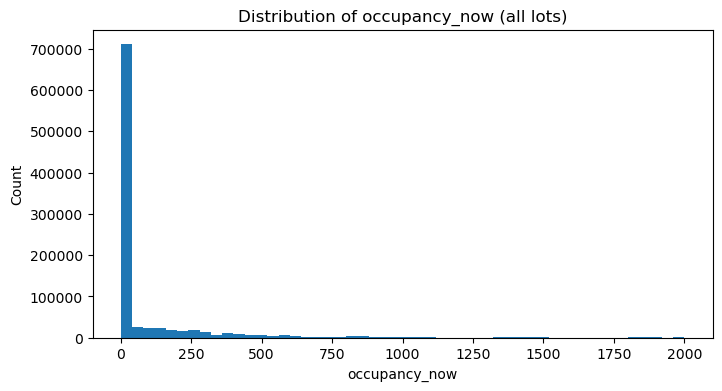

<Figure size 1000x500 with 0 Axes>

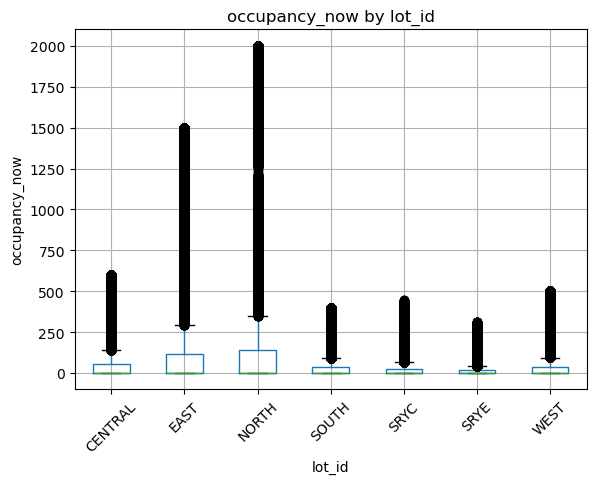

In [90]:
# drop nulls if any
occ = df["occupancy_now"].dropna()

plt.figure(figsize=(8, 4))
plt.hist(occ, bins=50)
plt.title("Distribution of occupancy_now (all lots)")
plt.xlabel("occupancy_now")
plt.ylabel("Count")
plt.show()

# Boxplot by lot_id

subset = df[df["lot_id"].isin(lots)]
plt.figure(figsize=(10, 5))
subset.boxplot(column="occupancy_now", by="lot_id", rot=45)
plt.title("occupancy_now by lot_id")
plt.suptitle("")
plt.xlabel("lot_id")
plt.ylabel("occupancy_now")
plt.show()

## Occupancy over time for one lot

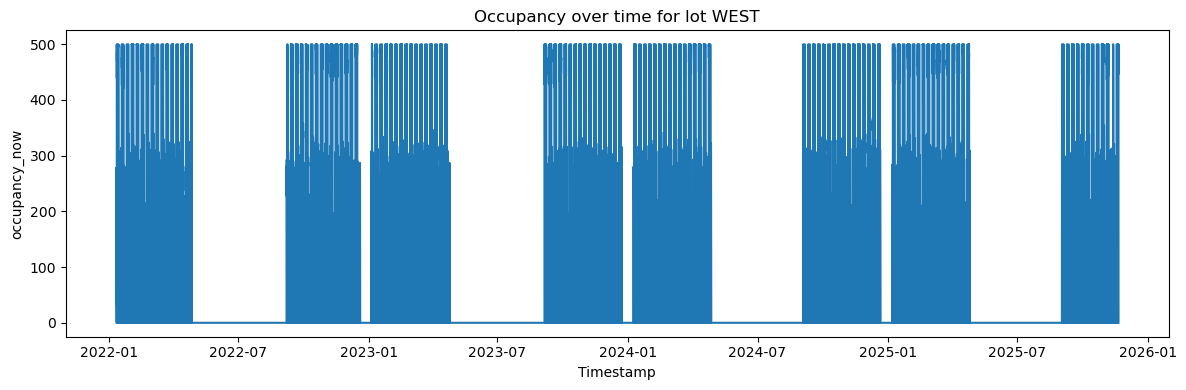

In [91]:
lot_id = df["lot_id"].iloc[0]
df_lot = df[df["lot_id"] == lot_id].sort_values("timestamp")

plt.figure(figsize=(12, 4))
plt.plot(df_lot["timestamp"], df_lot["occupancy_now"])
plt.title(f"Occupancy over time for lot {lot_id}")
plt.xlabel("Timestamp")
plt.ylabel("occupancy_now")
plt.tight_layout()
plt.show()

## Average occupancy by hour of day

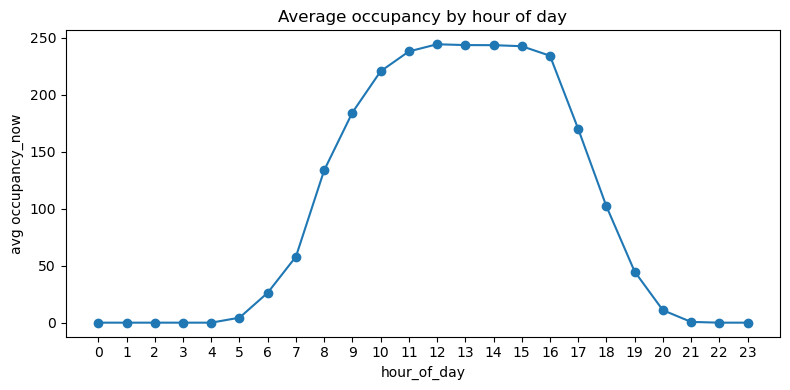

In [92]:
grouped = df.groupby("hour_of_day")["occupancy_now"].mean().reset_index()

plt.figure(figsize=(8, 4))
plt.plot(grouped["hour_of_day"], grouped["occupancy_now"], marker="o")
plt.title("Average occupancy by hour of day")
plt.xlabel("hour_of_day")
plt.ylabel("avg occupancy_now")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

This plot shows daily pattern - mornings ramping up, evenings down

## Occupancy patterns by day_of_week

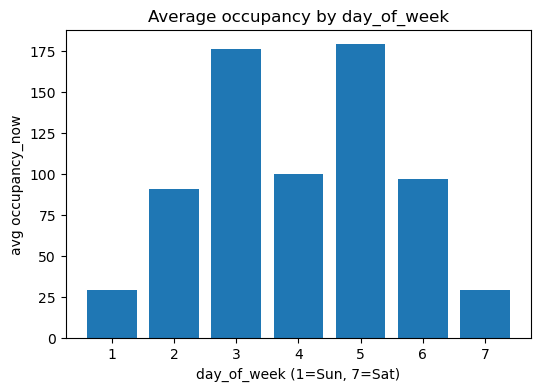

,day_of_week,occupancy_now
0,1,29.105573
1,2,90.386784
2,3,176.323005
3,4,99.644448
4,5,179.003199
5,6,96.480655
6,7,29.108239


In [93]:
avg_by_dow = df.groupby("day_of_week")["occupancy_now"].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.bar(avg_by_dow["day_of_week"], avg_by_dow["occupancy_now"])
plt.title("Average occupancy by day_of_week")
plt.xlabel("day_of_week (1=Sun, 7=Sat)")
plt.ylabel("avg occupancy_now")
plt.show()

avg_by_dow

## Time series trend over time

Using lot: WEST


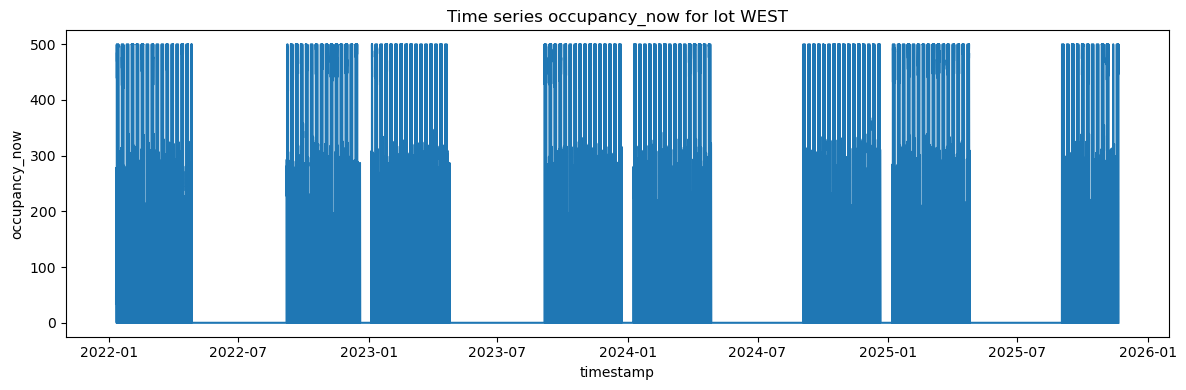

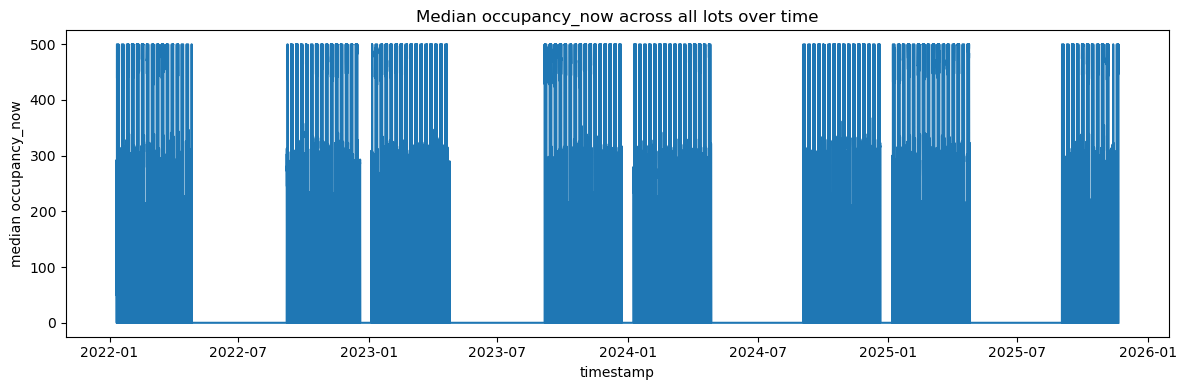

In [94]:
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# choose a single lot
lot_example = df["lot_id"].iloc[0]
print("Using lot:", lot_example)

df_lot = df[df["lot_id"] == lot_example].sort_values("timestamp")

plt.figure(figsize=(12, 4))
plt.plot(df_lot["timestamp"], df_lot["occupancy_now"])
plt.title(f"Time series occupancy_now for lot {lot_example}")
plt.xlabel("timestamp")
plt.ylabel("occupancy_now")
plt.tight_layout()
plt.show()

# Aggregate median occupancy across lots per timestamp
df_agg = df.groupby("timestamp")["occupancy_now"].median().reset_index()

plt.figure(figsize=(12, 4))
plt.plot(df_agg["timestamp"], df_agg["occupancy_now"])
plt.title("Median occupancy_now across all lots over time")
plt.xlabel("timestamp")
plt.ylabel("median occupancy_now")
plt.tight_layout()
plt.show()

## Capacity utilization check 

    lot_id  occupancy_now  capacity  over_capacity
0  CENTRAL            600       600          False
1     EAST           1500      1500          False
2    NORTH           2000      2000          False
3    SOUTH            400       400          False
4     SRYC            447       450          False
5     SRYE            311       450          False
6     WEST            500       500          False


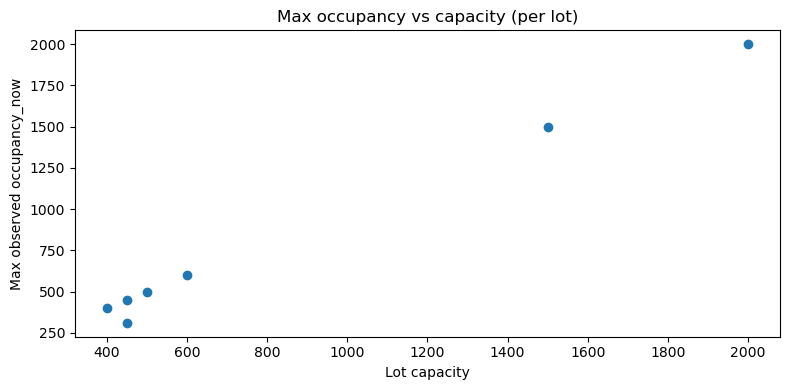

Lots where occupancy exceeded capacity:
Empty DataFrame
Columns: [lot_id, occupancy_now, capacity, over_capacity]
Index: []


In [95]:
BURNABY_LOTS = {
    "NORTH": 2000,
    "EAST": 1500,
    "CENTRAL": 600,
    "WEST": 500,
    "SOUTH": 400
}

SURREY_LOTS = {
    "SRYC": 450,
    "SRYE": 450
}

LOT_CAPACITY = {**BURNABY_LOTS, **SURREY_LOTS}

# making keys uppercase to match feature engineering
LOT_CAPACITY = {k.upper(): v for k, v in LOT_CAPACITY.items()}

# compute max observed occupancy per lot
max_occ = df.groupby("lot_id")["occupancy_now"].max().reset_index()
max_occ["capacity"] = max_occ["lot_id"].map(LOT_CAPACITY)

max_occ["over_capacity"] = max_occ["occupancy_now"] > max_occ["capacity"]

print(max_occ)

# plot max occupancy vs capacity for lots we know
mask_known = max_occ["capacity"].notna()
plt.figure(figsize=(8, 4))
plt.scatter(
    max_occ.loc[mask_known, "capacity"],
    max_occ.loc[mask_known, "occupancy_now"]
)
plt.xlabel("Lot capacity")
plt.ylabel("Max observed occupancy_now")
plt.title("Max occupancy vs capacity (per lot)")
plt.tight_layout()
plt.show()

print("Lots where occupancy exceeded capacity:")
print(max_occ[max_occ["over_capacity"]])

## Scatter: current vs +15 minutes

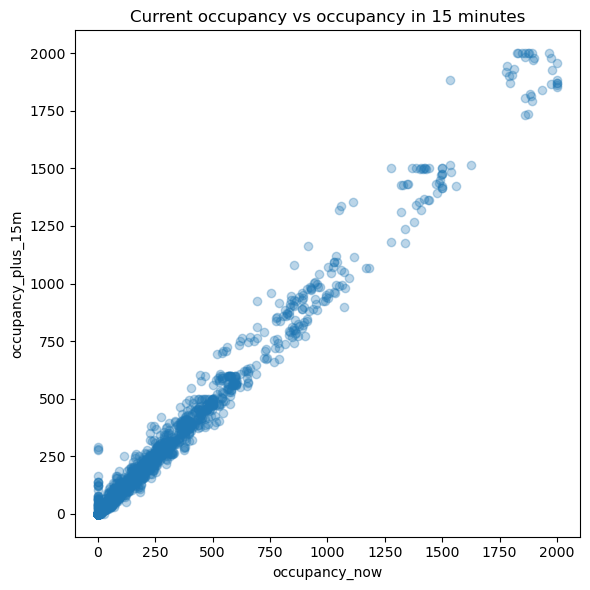

In [104]:
required_cols = {"occupancy_now", "occupancy_plus_15m"}

if not required_cols.issubset(df.columns):
    print("Need 'occupancy_now' and 'occupancy_plus_15m'; cannot make scatter.")
else:
    sample_size = min(len(df), 5000)
    sample = df.sample(sample_size, random_state=42) if sample_size > 0 else df

    plt.figure(figsize=(6, 6))
    plt.scatter(sample["occupancy_now"], sample["occupancy_plus_15m"], alpha=0.3)
    plt.title("Current occupancy vs occupancy in 15 minutes")
    plt.xlabel("occupancy_now")
    plt.ylabel("occupancy_plus_15m")
    plt.tight_layout()
    plt.show()

## Distribution of departures in 15 minutes

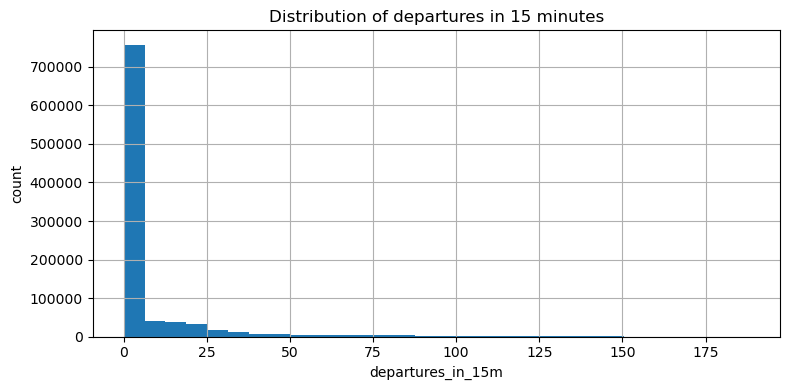

In [97]:
if "departures_in_15m" not in df.columns:
    print("No 'departures_in_15m' column; skipping histogram.")
else:
    plt.figure(figsize=(8, 4))
    df["departures_in_15m"].hist(bins=30)
    plt.title("Distribution of departures in 15 minutes")
    plt.xlabel("departures_in_15m")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [98]:
df["departures_in_15m"].max()
df.groupby("lot_id")["departures_in_15m"].max()

lot_id
CENTRAL     65
EAST       141
NORTH      188
SOUTH       47
SRYC        48
SRYE        33
WEST        59
Name: departures_in_15m, dtype: int64

## Holiday vs non-holiday occupancy

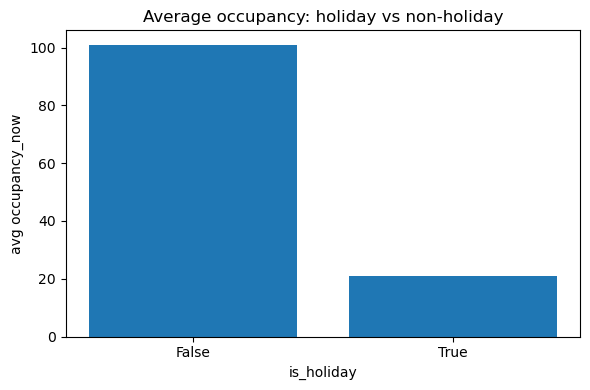

In [99]:
if "is_holiday" not in df.columns:
    print("No 'is_holiday' column; skipping holiday comparison.")
else:
    grouped = df.groupby("is_holiday")["occupancy_now"].mean().reset_index()

    plt.figure(figsize=(6, 4))
    plt.bar(grouped["is_holiday"].astype(str), grouped["occupancy_now"])
    plt.title("Average occupancy: holiday vs non-holiday")
    plt.xlabel("is_holiday")
    plt.ylabel("avg occupancy_now")
    plt.tight_layout()
    plt.show()

In [100]:
flag_cols = ["is_holiday", "is_weekend", "is_exam_week"]

for col in flag_cols:
    print(f"\n==== {col} ====")
    print(df[col].value_counts(dropna=False))


==== is_holiday ====
is_holiday
False    938490
True       9408
Name: count, dtype: int64

==== is_weekend ====
is_weekend
False    677754
True     270144
Name: count, dtype: int64

==== is_exam_week ====
is_exam_week
False    519624
True     428274
Name: count, dtype: int64


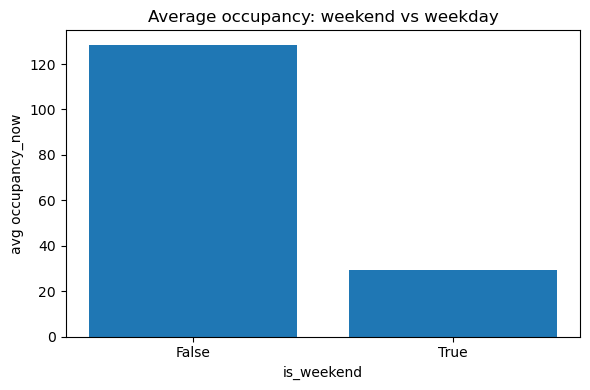

In [101]:
if "is_weekend" not in df.columns:
    print("No 'is_weeke d' column; skipping this comparison.")
else:
    grouped = df.groupby("is_weekend")["occupancy_now"].mean().reset_index()

    plt.figure(figsize=(6, 4))
    plt.bar(grouped["is_weekend"].astype(str), grouped["occupancy_now"])
    plt.title("Average occupancy: weekend vs weekday")
    plt.xlabel("is_weekend")
    plt.ylabel("avg occupancy_now")
    plt.tight_layout()
    plt.show()

In [102]:
grouped = df.groupby("is_holiday")["occupancy_now"].mean().reset_index()
print(grouped)

holiday_occ = df[df["is_holiday"] == True]["occupancy_now"]
print(holiday_occ.describe())

print("Holiday rows with occupancy_now > 0:",
      (holiday_occ > 0).sum())

   is_holiday  occupancy_now
0       False     100.901090
1        True      20.881165
count    9408.000000
mean       20.881165
std        52.567810
min         0.000000
25%         0.000000
50%         0.000000
75%         9.000000
max       475.000000
Name: occupancy_now, dtype: float64
Holiday rows with occupancy_now > 0: 2755


## Correlation heatmap for features

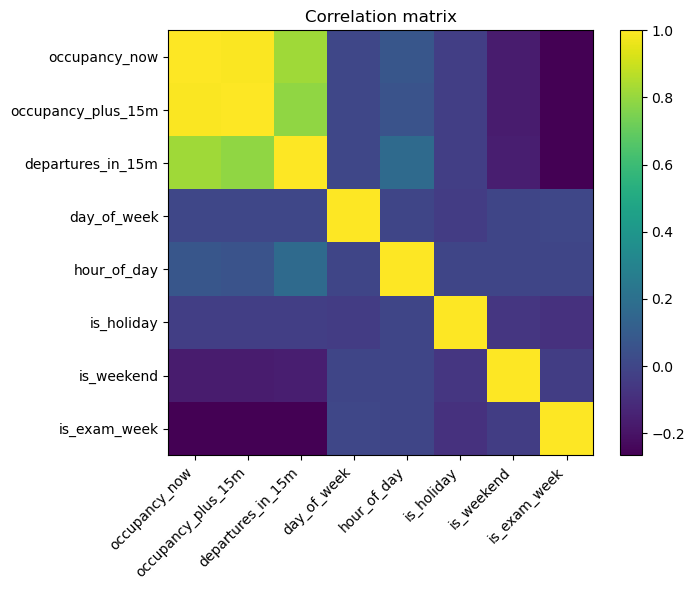

,occupancy_now,occupancy_plus_15m,departures_in_15m,day_of_week,hour_of_day,is_holiday,is_weekend,is_exam_week
occupancy_now,1.000000,0.994587,0.818843,0.004054,0.073894,-0.030238,-0.170874,-0.265730
occupancy_plus_15m,0.994587,1.000000,0.787964,0.004056,0.059586,-0.030238,-0.170873,-0.265706
departures_in_15m,0.818843,0.787964,1.000000,0.004202,0.171864,-0.028909,-0.161567,-0.260920
day_of_week,0.004054,0.004056,0.004202,1.000000,-0.000330,-0.039317,0.000322,0.004131
hour_of_day,0.073894,0.059586,0.171864,-0.000330,1.000000,-0.000016,-0.000100,0.000664
is_holiday,-0.030238,-0.030238,-0.028909,-0.039317,-0.000016,1.000000,-0.063211,-0.084311
is_weekend,-0.170874,-0.170873,-0.161567,0.000322,-0.000100,-0.063211,1.000000,-0.037225
is_exam_week,-0.265730,-0.265706,-0.260920,0.004131,0.000664,-0.084311,-0.037225,1.000000


In [105]:
feature_cols = [
    "occupancy_now",
    "occupancy_plus_15m",
    "departures_in_15m",
    "day_of_week",
    "hour_of_day",
]

for flag_col in ["is_holiday", "is_weekend", "is_exam_week"]:
    if flag_col in df.columns:
        feature_cols.append(flag_col)

num_df = df[feature_cols].copy()

for col in ["is_holiday", "is_weekend", "is_exam_week"]:
    if col in num_df.columns:
        num_df[col] = num_df[col].astype(float)

corr = num_df.corr()

plt.figure(figsize=(8, 6))
im = plt.imshow(corr.values, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

corr

##### There is a very high correlation between occupancy_now and occupancy_plus_15m and departures_in_15m. If a lot is full now, it is likely still quite full 15 minutes from now. There is slight negative correlation for is_weekend and is_exam_week. 